# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109B Introduction to Data Science
## Lab 3: Optimization in Artificial Neural Networks

**Harvard University**<br>
**Spring 2019**<br>
**Lab instructor** Eleni Kaxiras<br>
**Instructors:** Pavlos Protopapas and Mark Glickman<br>

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals
In this lab, we'll explore ways to optimize the loss function of a Multilayer Learning Perceptor (MLP) by tuning the model hyperparameters. We'll also explore the use of cross-validation as a technique for checking potential values for these hyperparameters.

By the end of this lab, you should:
- Be familiar with the use of `sklearn`'s `optimize` function.
- Be able to identify the hyperparameters that go into the training of a MLP.
- Be familiar with the implementation in `keras` of various optimization techniques.
- Apply cross-validation to check for multiple values of hyperparameters.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

%matplotlib inline

## Part 1:  Beale's function
### First let's look at function optimization in `scipy.optimize`, using Beale's function as an example

Optimizing a function $f: A\rightarrow R$, from some set A to the real numbers is finding an element $x_0\,\epsilon\, A$ such that $f(x_0)\leq f(x)$ for all $x\,\epsilon\, A$ (finding the minimum) or such that $f(x_0)\geq f(x)$ for all $x\,\epsilon\, A$ (finding the maximum).

To illustrate our point we will use a function of two parameters.  Our goal is to optimize over these 2 parameters. We can extend to higher dimensions by plotting pairs of parameters against each other.

The Wikipedia article on Test functions for optimization has a few functions that are useful for evaluating optimization algorithms. Here is Beale's function:

$f(x,y)$ = $(1.5−x+xy)^2+(2.25−x+xy^2)^2+(2.625−x+xy^3)^2$

\[source:[Wikipedia](https://en.wikipedia.org/wiki/Test_functions_for_optimization)\]

We already know that this function has a minimum at [3.0, 0.5]. Let's see if `scipy` will find it.

![alt text](Bealesfunction.jpg)

In [3]:
# define Beale's function which we want to minimize
def objective(X):
    x = X[0]; y = X[1]
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [4]:
# function boundaries
xmin, xmax, xstep = -4.5, 4.5, .9
ymin, ymax, ystep = -4.5, 4.5, .9

In [5]:
# Let's create some points
x1, y1 = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

Let's make an initial guess

In [6]:
# initial guess
x0 = [4., 4.]  
f0 = objective(x0)
print (f0)

68891.203125


In [7]:
bnds = ((xmin, xmax), (ymin, ymax))
minimum = minimize(objective, x0, bounds=bnds)

In [8]:
print(minimum)

      fun: 2.068025638865627e-12
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.55969780e-06,  9.89837957e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 14
   status: 0
  success: True
        x: array([3.00000257, 0.50000085])


In [9]:
real_min = [3.0, 0.5]
print (f'The answer, {minimum.x}, is very close to the optimum as we know it, which is {real_min}') 
print (f'The value of the objective for {real_min} is {objective(real_min)}')

The answer, [3.00000257 0.50000085], is very close to the optimum as we know it, which is [3.0, 0.5]
The value of the objective for [3.0, 0.5] is 0.0


## Part 2: Optimization in neural networks

In general: **Learning Representation --> Objective function --> Optimization algorithm**

A neural network can be defined as a framework that combines inputs and tries to guess the output. If we are lucky enough to have some results, called "the ground truth", to compare the outputs produced by the network, we can calculate the **error**. So the network guesses, calculates some error function, guesses again, trying to minimize this error, guesses again, until the error does not go down any more. This is optimization.  

In neural networks the most common used optimization algorithms, are flavors of **GD (gradient descent)**. The *objective function* used in gradient descent is the *loss function* which we want to minimize .

### A `keras` Refresher

`Keras` is a Python library for deep learning that can run on top of both Theano or
TensorFlow, two powerful Python libraries for fast numerical computing created and released by Facebook and Google, respectevely.

Keras was developed to make developing deep learning models as fast and easy as
possible for research and practical applications. It runs on Python 2.7 or 3.5 and can seamlessly execute on GPUs and CPUs.

Keras is built on the idea of a model. At its core we have a sequence of layers called
the `Sequential` model which is a linear stack of layers. Keras also provides the `functional API`, a way to define complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

We can summarize the construction of deep learning models in Keras using the Sequential model as follows:
1. **Define your model**: create a `Sequential` model and add layers.
2. **Compile your model**: specify loss function and optimizers and call the `.compile()` function.
3. **Fit your model**: train the model on data by calling the `.fit()` function.
4. **Make predictions**: use the model to generate predictions on new data by calling functions such as `.evaluate()` or `.predict()`.

### Callbacks: taking a peek into our model while it's training

You can look at what is happening in various stages of your model by using `callbacks`. A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the `.fit()` method of the Sequential or Model classes. The relevant methods of the callbacks will then be called at each stage of the training.

- A callback function you are already familiar with is `keras.callbacks.History()`. This is automatically included in `.fit()`.


- Another very useful one is `keras.callbacks.ModelCheckpoint` which saves the model with its weights at a certain point in the training. This can prove useful if your model is running for a long time and a system failure happens. Not all is lost then. It's a good practice to save the model weights only when an improvement is observed as measured by the `acc`, for example.


- `keras.callbacks.EarlyStopping` stops the training when a monitored quantity has stopped improving.


- `keras.callbacks.LearningRateScheduler` will change the learning rate during training.


We will apply some callbacks later.

For full documentation on `callbacks` see https://keras.io/callbacks/

### What are the steps to optimizing our network?

In [10]:
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras import losses
from sklearn.utils import shuffle

print(tf.VERSION)
print(tf.keras.__version__)

# fix random seed for reproducibility
np.random.seed(5)

1.12.0
2.1.6-tf


Using TensorFlow backend.


### Step 1 -  Deciding on the network topology (not really considered optimization but is obviously very important)

We will use the MNIST dataset which consists of grayscale images of handwritten digits (0-9) whose dimension is 28x28 pixels. Each pixel is 8 bits so its value ranges from 0 to 255.

In [11]:
#mnist = tf.keras.datasets.mnist
mnist = keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

Each label is a number between 0 and 9

In [12]:
print(y_train)

[5 0 4 ... 5 6 8]


Let's look at some 10 of the images

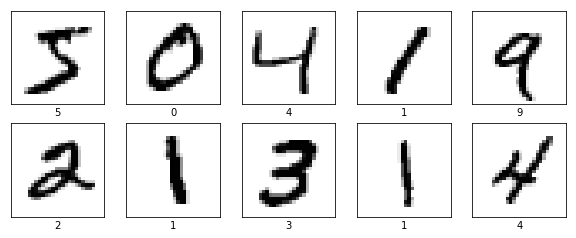

In [13]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])

In [16]:
print(x_train[45].shape)
x_train[45, 15:20, 15:20]

(28, 28)


array([[ 11, 198, 231,  41,   0],
       [ 82, 252, 204,   0,   0],
       [253, 253, 141,   0,   0],
       [252, 220,  36,   0,   0],
       [252,  96,   0,   0,   0]], dtype=uint8)

In [15]:
print(f'We have {x_train.shape[0]} train samples')
print(f'We have {x_test.shape[0]} test samples')

We have 60000 train samples
We have 10000 test samples


#### Preprocessing the data

To run our NN we need to pre-process the data

* First we need to make the 2D image arrays into 1D (flatten them). We can either perform this by using array reshaping with `numpy.reshape()` or the `keras`' method for this: a layer called `tf.keras.layers.Flatten` which transforms the format of the images from a 2d-array (of 28 by 28 pixels), to a 1D-array of 28 * 28 = 784 pixels. 

* Then we need to normalize the pixel values (give them values between 0 and 1) using the following transformation:

\begin{align}
x := \dfrac{x - x_{min}}{x_{max} - x_{min}} 
\textrm{}
\end{align}

In our case $x_{min} = 0$ and $x_{max} = 255$ so the formula becomes simply $x := {x}/255$ 

In [17]:
# normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

In [18]:
# reshape the data into 1D vectors
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

num_classes = 10

In [19]:
x_train.shape[1]

784

Now let's prepare our class vector (y) to a binary class matrix, e.g. for use with categorical_crossentropy.

In [20]:
# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [21]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

Now we are ready to build the model!

### Step 2 - Adjusting the `learning rate`

One of the most common optimization algorithm is Stochastic Gradient Descent (SGD). The hyperparameters that can be optimized in SGD are `learning rate`, `momentum`, `decay` and `nesterov`.

`Learning rate` controls the weight at the end of each batch, and `momentum` controls how much to let the previous update influence the current weight update. `Decay` indicates the learning rate decay over each update, and `nesterov` takes the value True or False depending on if we want to apply Nesterov momentum. Typical values for those hyperparameters are lr=0.01, decay=1e-6, momentum=0.9, and nesterov=True. 

The learning rate hyperparameter goes into the `optimizer` function which we will see below.

![learning rates](learningrates.jpeg)

Let's implement a learning rate adaptation schedule in `Keras`. We'll start with SGD and a learning rate value of 0.1. We will then train the model for 40
epochs and set the decay argument to 0.002 (0.1/50). We also include a momentum value of 0.8 since that seems to work well when using an adaptive learning rate. 

In [22]:
epochs = 60
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [23]:
# build the model
input_dim = x_train.shape[1]

lr_model = Sequential()
lr_model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', 
                input_dim = input_dim)) # fully-connected layer with 64 hidden units
lr_model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

# compile the model
lr_model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['acc'])

In [24]:
%%time
# Fit the model
batch_size = 28

lr_model_history = lr_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 4s 73us/step - loss: 0.2859 - acc: 0.9069 - val_loss: 0.1374 - val_acc: 0.9579
Epoch 2/60
60000/60000 [==============================] - 4s 58us/step - loss: 0.1046 - acc: 0.9683 - val_loss: 0.1046 - val_acc: 0.9676
Epoch 3/60
60000/60000 [==============================] - 3s 58us/step - loss: 0.0780 - acc: 0.9767 - val_loss: 0.0928 - val_acc: 0.9723
Epoch 4/60
60000/60000 [==============================] - 3s 57us/step - loss: 0.0647 - acc: 0.9809 - val_loss: 0.0878 - val_acc: 0.9747
Epoch 5/60
60000/60000 [==============================] - 3s 56us/step - loss: 0.0571 - acc: 0.9832 - val_loss: 0.0859 - val_acc: 0.9747
Epoch 6/60
60000/60000 [==============================] - 3s 53us/step - loss: 0.0515 - acc: 0.9849 - val_loss: 0.0840 - val_acc: 0.9756
Epoch 7/60
60000/60000 [==============================] - 3s 53us/step - loss: 0.0470 - acc: 0.9863 - val_loss: 0.0853 - val_acc

60000/60000 [==============================] - 3s 54us/step - loss: 0.0166 - acc: 0.9968 - val_loss: 0.0851 - val_acc: 0.9771
CPU times: user 5min 48s, sys: 1min 23s, total: 7min 11s
Wall time: 3min 20s


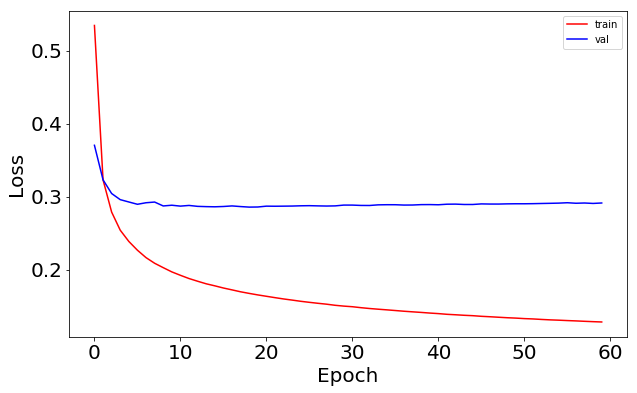

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

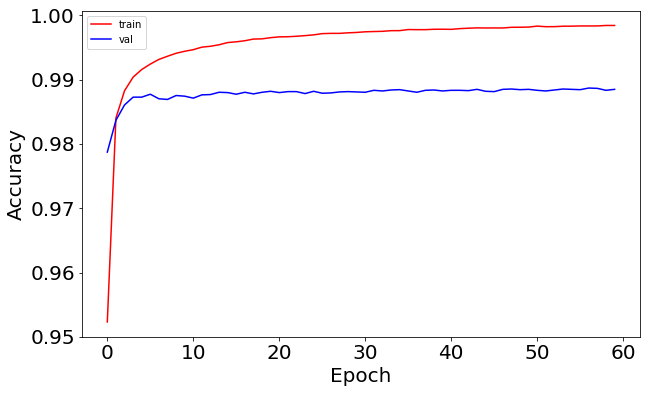

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['acc']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_acc']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

**Exercise:** Write a function that performs exponential learning rate decay using `LearningRateScheduler`

$lr = lr0*e^{(-kt)}$ t is the iteration number

### Step 3 - Choosing an `optimizer` and a `loss function`

When constructing a model and using it to make our predictions, for example to assign label scores to images ("cat", "plane", etc), we want to measure our success or failure by defining a "loss" function (or objective function). The goal of optimization is to efficiently calculate the parameters/weights that minimize this loss function. `keras` provides various types of [loss functions](https://github.com/keras-team/keras/blob/master/keras/losses.py).

Sometimes the "loss" function measures the "distance". We can define this "distance" between two data points in various ways suitable to the problem or dataset.

Distance 

- Euclidean 
- Manhattan
- others such as Hamming which measures distances between strings, for example. The Hamming distance of "carolin" and "cathrin" is 3.

Loss functions
- MSE (for regression)
- categorical cross-entropy (for classification)
- binary cross entropy (for classification)

In [27]:
# build the model
input_dim = x_train.shape[1]

model = Sequential()
model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', 
                input_dim = input_dim)) # fully-connected layer with 64 hidden units
#model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

In [28]:
# defining the parameters for RMSprop (I used the keras defaults here)
rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=rms,
              metrics=['acc'])

### Step 4 - Deciding on the `batch size` and `number of epochs`

In [29]:
%%time
batch_size = 32
epochs = 20

model_history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 58us/step - loss: 0.3924 - acc: 0.8847 - val_loss: 0.2036 - val_acc: 0.9383
Epoch 2/20
60000/60000 [==============================] - 3s 53us/step - loss: 0.1732 - acc: 0.9494 - val_loss: 0.1349 - val_acc: 0.9588
Epoch 3/20
60000/60000 [==============================] - 3s 53us/step - loss: 0.1246 - acc: 0.9637 - val_loss: 0.1142 - val_acc: 0.9647
Epoch 4/20
60000/60000 [==============================] - 3s 56us/step - loss: 0.1008 - acc: 0.9708 - val_loss: 0.1180 - val_acc: 0.9678
Epoch 5/20
60000/60000 [==============================] - 3s 54us/step - loss: 0.0872 - acc: 0.9753 - val_loss: 0.1014 - val_acc: 0.9732
Epoch 6/20
60000/60000 [==============================] - 3s 56us/step - loss: 0.0761 - acc: 0.9786 - val_loss: 0.1262 - val_acc: 0.9683
Epoch 7/20
60000/60000 [==============================] - 4s 58us/step - loss: 0.0685 - acc: 0.9806 - val_loss: 0.1107 - val_acc

In [30]:
from sklearn.metrics import r2_score as r2

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test R2:', r2(y_test, model.predict(x_test)))

Test loss: 0.18207394694871187
Test accuracy: 0.9693
Test R2: 0.9419778253787543


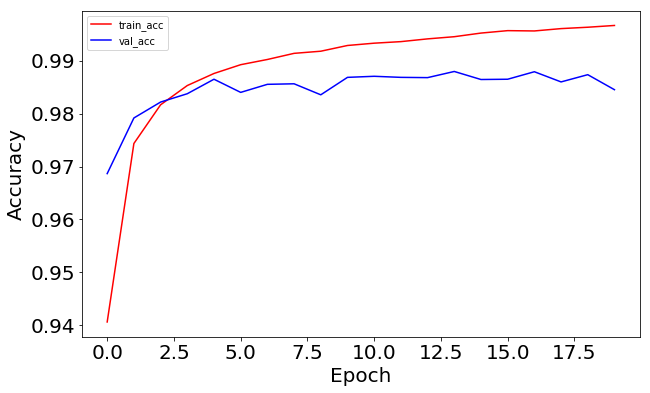

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['acc']), 'r', label='train_acc')
ax.plot(np.sqrt(model_history.history['val_acc']), 'b' ,label='val_acc')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

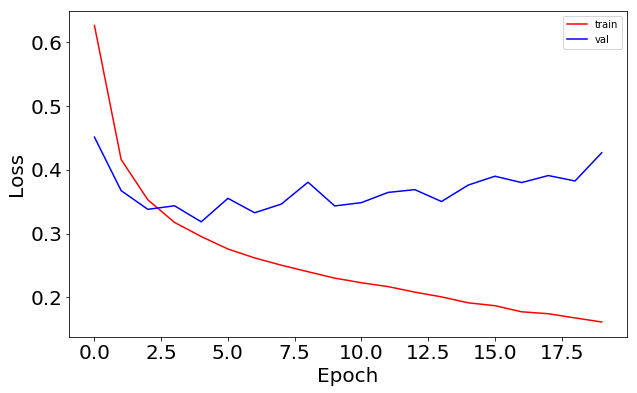

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [33]:
print(model_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


### Step 5 - Random restarts

This method does not seem to have an implementation in `keras`. We will leave it as a home exercise!

Hint: you can use `keras.callbacks.LearningRateScheduler`.


### Tuning the Hyperparameters using Cross Validation

Now instead of trying different values by hand, we will use GridSearchCV from Scikit-Learn to try out several values for our hyperparameters and compare the results.

To do cross-validation with `keras` we will use the wrappers for the Scikit-Learn API. They provide a way to use Sequential Keras models (single-input only) as part of your Scikit-Learn workflow.

There are two wrappers available:

`keras.wrappers.scikit_learn.KerasClassifier(build_fn=None, **sk_params)`, which implements the Scikit-Learn classifier interface,

`keras.wrappers.scikit_learn.KerasRegressor(build_fn=None, **sk_params)`, which implements the Scikit-Learn regressor interface.

In [34]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

#### Trying different weight initializations

In [35]:
# Function to create model, required for KerasClassifier
def create_model(init_mode='uniform'):
    # define model
    model = Sequential()
    model.add(Dense(64, kernel_initializer=init_mode, activation=tf.nn.relu, input_dim=784)) 
    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_initializer=init_mode, activation=tf.nn.relu))
    model.add(Dropout(0.5))
    model.add(Dense(10, kernel_initializer=init_mode, activation=tf.nn.softmax))
    # compile model
    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
    return model

In [36]:
%%time
seed = 7
numpy.random.seed(seed)
batch_size = 128
epochs = 10

model_CV = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.949333 using {'init_mode': 'lecun_uniform'}
0.945850 (0.002531) with: {'init_mode': 'uniform'}
0.949333 (0.001327) with: {'init_mode': 'lecun_uniform'}
0.947133 (0.001782) with: {'init_mode': 'normal'}
0.112367 (0.002416) with: {'init_mode': 'zero'}
0.947533 (0.001002) with: {'init_mode': 'glorot_normal'}
0.949117 (0.001478) with: {'init_mode': 'glorot_uniform'}
0.946383 (0.003040) with: {'init_mode': 'he_normal'}
0.947383 (0.001852) with: {'init_mode': 'he_uniform'}
CPU times: user 25.4 s, sys: 5.71 s, total: 31.1 s
Wall time: 1min 51s


### Save Your Neural Network Model to JSON

The Hierarchical Data Format (HDF5) is a data storage format for storing large arrays of data including values for the weights in a neural network.
You can install HDF5 Python module: pip install h5py

Keras gives you the ability to describe and save any model using the JSON format.

In [37]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# save weights to HDF5
model.save_weights("model.h5")
print("Model saved")

# when you want to retrieve the model: load json and create model
json_file = open('model.json', 'r')
saved_model = json_file.read()
# close the file as good practice
json_file.close()
model_from_json = model_from_json(saved_model)
# load weights into new model
model_from_json.load_weights("model.h5")
print("Model loaded")

Model saved
Model loaded


### Exercise 1: Perform a GridSearch for Learning rate and number of epochs combined

We will try various small standard learning rates, and momentum values from 0.1 to 0.9 in steps of 0.2.

We want to include the number of epochs in an optimization as there is a dependency between the learning rate, the batch size, and the number of epochs.

In [38]:
# Function to create model, required for KerasClassifier
def create_model2(lr=0.01, momentum=0.9):
    # define model
    model = Sequential()
    model.add(Dense(64, activation=tf.nn.relu, input_dim=784)) 
    model.add(Dropout(0.5))
    model.add(Dense(64, activation=tf.nn.relu))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation=tf.nn.softmax))
    # compile model
    model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=lr, momentum=momentum),
              metrics=['accuracy'])
    return model

In [41]:
%%time
seed = 12
numpy.random.seed(seed)
batch_size = 128
epochs = 10

model_CV = KerasClassifier(build_fn=create_model2, epochs=epochs, batch_size=batch_size, verbose=0)
# define the grid search parameters
lrs = [0.001, 0.01, 0.05, 0.1]
momentums = [0.1,0.3,0.5,0.7,0.9]

param_grid = dict(lr=lrs,momentum=momentums)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.947433 using {'lr': 0.1, 'momentum': 0.7}
0.644717 (0.044976) with: {'lr': 0.001, 'momentum': 0.1}
0.726167 (0.010186) with: {'lr': 0.001, 'momentum': 0.3}
0.780017 (0.010354) with: {'lr': 0.001, 'momentum': 0.5}
0.838217 (0.011302) with: {'lr': 0.001, 'momentum': 0.7}
0.892733 (0.004777) with: {'lr': 0.001, 'momentum': 0.9}
0.894867 (0.005373) with: {'lr': 0.01, 'momentum': 0.1}
0.901750 (0.003902) with: {'lr': 0.01, 'momentum': 0.3}
0.911750 (0.003221) with: {'lr': 0.01, 'momentum': 0.5}
0.922217 (0.004031) with: {'lr': 0.01, 'momentum': 0.7}
0.941050 (0.001995) with: {'lr': 0.01, 'momentum': 0.9}
0.936417 (0.003528) with: {'lr': 0.05, 'momentum': 0.1}
0.937250 (0.003182) with: {'lr': 0.05, 'momentum': 0.3}
0.941383 (0.004048) with: {'lr': 0.05, 'momentum': 0.5}
0.946967 (0.002925) with: {'lr': 0.05, 'momentum': 0.7}
0.946200 (0.002777) with: {'lr': 0.05, 'momentum': 0.9}
0.944200 (0.002947) with: {'lr': 0.1, 'momentum': 0.1}
0.943217 (0.003100) with: {'lr': 0.1, 'momentum': 